In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rules import *

G = Rules().graph

In [2]:
def path_sign(graph, path):
    sign = 1
    for i in range(1, len(path)):
        sign = sign * graph[path[i-1]][path[i]]['weight']
    return sign

def path_to_str(graph, path):
    res = path[0]
    for i in range(1, len(path)):        
        res = res + ' -{} {}'.format(['>', '|'][graph[path[i-1]][path[i]]['weight'] < 0], path[i])
    return res

In [3]:
feedbackLoops = {'neg': [], 'pos': []}
for cycle in nx.cycles.simple_cycles(G):    
    path = cycle + [cycle[0]]
    if path_sign(graph=G, path=path) > 0:
        feedbackLoops['pos'].append(path)
    else:
        feedbackLoops['neg'].append(path)
    
# feedbackLoops

In [4]:
depMatrix = pd.DataFrame()
for source in G.node:
    for target in G.node:
        isPositive = False
        isNegative = False
        isNegativeLoop = False
        for path in nx.all_simple_paths(G, source, target):
            if path_sign(graph=G, path=path) > 0:
                isPositive = True
            else:
                isNegative = True
                
            for loop in feedbackLoops["neg"]:
                if len(set(path) & set(loop)) > 0:
                    isNegativeLoop = True
                    break
            
                
        if isPositive and isNegative:
            depMatrix.set_value(source, target, 3)
        elif isPositive:
            depMatrix.set_value(source, target, [2, 1][isNegativeLoop])
        elif isNegative:
            depMatrix.set_value(source, target, [-2, -1][isNegativeLoop])
        else:
            depMatrix.set_value(source, target, 0)
                
# depMatrix


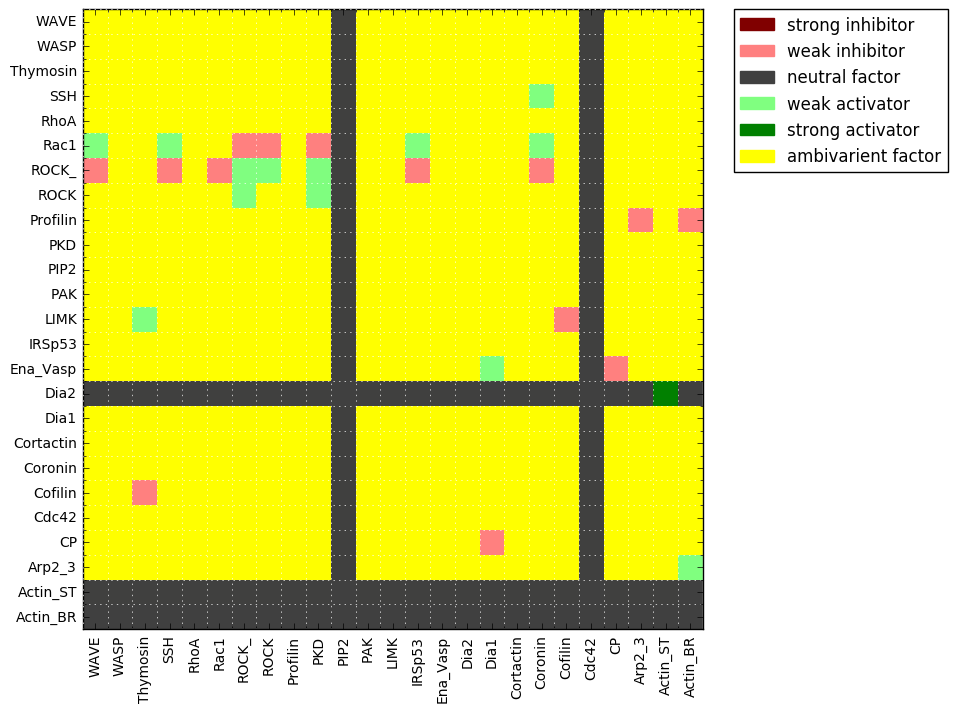

In [5]:
from matplotlib import colors
from matplotlib import patches

colorMap = [
    {'color': '#800000', 'label': "strong inhibitor"},
    {'color': '#ff8080', 'label': "weak inhibitor"},
    {'color': '#404040', 'label': "neutral factor"},
    {'color': '#80ff80', 'label': "weak activator"},
    {'color': '#008000', 'label': "strong activator"},    
    {'color': '#ffff00', 'label': "ambivarient factor"}]

cmap = colors.ListedColormap([val['color'] for val in colorMap])
legend = [patches.Patch(color=val['color'], label=val['label']) for val in colorMap]
    
df = depMatrix.sort_index(ascending=False).sort_index(ascending=False, axis=1)

plt.figure(figsize=(10,8))
im = plt.imshow(df, interpolation='none', cmap=cmap, vmin=-2, vmax=3);
plt.yticks(range(df.shape[0]), df.columns);
plt.xticks(range(df.shape[1]), df.index, rotation=90);

ax = plt.gca()
ax.set_yticks(np.arange(-.5, df.shape[0], 1), minor=True);
ax.set_xticks(np.arange(-.5, df.shape[1], 1), minor=True);
plt.grid(which="minor", color="w");
plt.legend(handles=legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. );
plt.savefig('dependency_matrix.png', bbox_inches='tight');
